In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import intake 
import os
import xarray as xr
import cftime

In [76]:
# CMIP6 data catalog location (adjust if needed)
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

query_simon = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["sispeed","siconc"]
)
df_simon = query_simon.df

query_ofx = col.search(
    experiment_id="historical",
    table_id="Ofx",
    variable_id=["areacello"]
)
df_ofx = query_ofx.df

print(df_simon.head())
print(df_ofx.head())

  activity_id institution_id  source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r3i1p1f1    SImon   
1        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r3i1p1f1    SImon   
2        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r2i1p1f1    SImon   
3        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r2i1p1f1    SImon   
4        CMIP      NOAA-GFDL   GFDL-CM4    historical  r1i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
1      siconc         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
2      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
3      siconc         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
4     sispeed         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   

   dcpp_init_year   version  
0             NaN  20180701  
1       

In [77]:
# Count ensembles per model
ensemble_count = df.groupby('source_id')['member_id'].nunique()
ensemble_count_df = ensemble_count.reset_index()
ensemble_count_df.columns = ['Model', 'Number_of_Ensembles']

# Filter models with ≥10 ensembles
filter_df = ensemble_count_df[ensemble_count_df['Number_of_Ensembles'] >= 10]
selected_models = filter_df['Model'].tolist()

print("Models with ≥10 ensembles:\n", selected_models)


Models with ≥10 ensembles:
 ['ACCESS-ESM1-5', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'EC-Earth3', 'GISS-E2-1-G', 'GISS-E2-1-H', 'INM-CM5-0', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorCPM1', 'UKESM1-0-LL']


In [81]:
chosen_model = "CESM2" 

filter_model = query.df[query.df['source_id'] == chosen_model]

for _, row in filter_model.iterrows():
    member_id = row['member_id']
    dataset_url = row['zstore']

    print(f"\nEnsemble: {member_id}")

    try:
        ds = xr.open_zarr(dataset_url, consolidated=False) 
        print(f"Available variables: {list(ds.data_vars.keys())}")
    )

SyntaxError: unmatched ')' (2120004364.py, line 14)

In [44]:
query = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["sispeed", "siconc"]
)
df = query.df

cesm2_df = df[df['source_id'] == "CESM2"]
print("CESM2 query records:")
print(cesm2_df.head())

cesm2_zstore = cesm2_df.iloc[0]['zstore']

cesm2_ds = xr.open_zarr(cesm2_zstore, consolidated=True)

# Print the dataset summary and its coordinates
print("CESM2 Dataset Summary:")
print(cesm2_ds)
print("\nCoordinates for CESM2:")
print(cesm2_ds.coords)


CESM2 query records:
    activity_id institution_id source_id experiment_id member_id table_id  \
115        CMIP           NCAR     CESM2    historical  r1i1p1f1    SImon   
116        CMIP           NCAR     CESM2    historical  r1i1p1f1    SImon   
117        CMIP           NCAR     CESM2    historical  r4i1p1f1    SImon   
118        CMIP           NCAR     CESM2    historical  r4i1p1f1    SImon   
119        CMIP           NCAR     CESM2    historical  r5i1p1f1    SImon   

    variable_id grid_label                                             zstore  \
115      siconc         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...   
116     sispeed         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...   
117     sispeed         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...   
118      siconc         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4...   
119     sispeed         gn  gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...   

     dcpp_init_year   version

In [12]:
##############################################
# Full Code for Checking CMIP6 Variables
##############################################

import intake
import pandas as pd
import numpy as np

# 1. Load the CMIP6 data catalog
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

# 2. Define the variables to query
variables = ['siu', 'siv', 'siconc', 'sfcWind', 'sithick']

# 3. Construct the query
query = col.search(
    experiment_id=['historical'],       # Historical experiment
    table_id=['SImon', 'Amon'],         # Sea ice table (SImon) + atmospheric table (Amon)
    member_id='r1i1p1f1',               # Single ensemble
    variable_id=variables               # Variables of interest
)

# Convert the query result into a DataFrame
df = query.df
print("First 5 rows of the query:")
print(df.head())

##############################################
# 4. Group by Model and Check Variables
##############################################
complete_list = []   # models that have all variables
incomplete = []      # models that miss at least one variable

# Group the query DataFrame by 'source_id' (model name)
for name, group in df.groupby('source_id'):
    # For each variable in 'variables', check if it exists in 'group["variable_id"]'
    check_variables = [v in group['variable_id'].values for v in variables]

    # has_data = True only if *all* requested variables are found
    has_data = np.all(check_variables)

    if has_data:
        # This model has all the requested variables
        complete_list.append(name)
    else:
        # This model is missing at least one variable
        missing = [v for v in variables if v not in group['variable_id'].values]
        # Record info for debugging
        incomplete.append([
            name, 
            len(group),            # number of rows for this model
            ','.join(missing),     # which variables are missing
            has_data               # will be False
        ])

##############################################
# 5. Create a DataFrame of Incomplete Models
##############################################
incomplete_df = pd.DataFrame(
    incomplete, 
    columns=['source_id', 'n_rows', 'missing_variables', 'has_all_variables']
)

##############################################
# 6. Display Results
##############################################
print("\n==========================")
print("Models that have ALL variables:")
print(complete_list)

print("\n==========================")
print("Incomplete Models DataFrame:")
print(incomplete_df)

##############################################
# End of Script
##############################################


First 5 rows of the query:
  activity_id institution_id source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1     Amon   
1        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   
2        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   
3        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   
4        CMIP      NOAA-GFDL  GFDL-CM4    historical  r1i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0     sfcWind        gr1  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
1         siu         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
2         siv         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
3     sithick         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
4     sithick         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   

   dcpp_init_year   version  
0             NaN

In [74]:
chosen_model = "CESM2"
chosen_ensemble = "r1i1p1f1" 
query_filtered = col.df[
    (col.df['source_id'] == chosen_model) &
    (col.df['member_id'] == chosen_ensemble)
]

available_vars = query_filtered['variable_id'].unique()

print(f"Available variables for {chosen_model}, Ensemble {chosen_ensemble}:")
print(sorted(available_vars))


Available variables for CESM2, Ensemble r1i1p1f1:
['abs550aer', 'agessc', 'airmass', 'areacella', 'areacello', 'baresoilFrac', 'bddtalk', 'bddtdic', 'bddtdife', 'bddtdin', 'bddtdip', 'bddtdisi', 'burntFractionAll', 'cCwd', 'cLeaf', 'cLitter', 'cProduct', 'cRoot', 'cSoil', 'cSoilFast', 'cSoilMedium', 'cSoilSlow', 'cVeg', 'calc', 'cdnc', 'cfc11', 'cfc11global', 'cfc12', 'cfc12global', 'ch4global', 'chl', 'chldiat', 'chldiatos', 'chldiaz', 'chldiazos', 'chlos', 'chlpico', 'ci', 'cl', 'cli', 'clivi', 'clt', 'cltc', 'clw', 'clwvi', 'co2', 'co2mass', 'co3', 'co3satarag', 'co3satcalc', 'cod', 'cropFrac', 'dcalc', 'deptho', 'dfe', 'dfeos', 'diftrblo', 'diftrelo', 'dissi14cabio', 'dissic', 'dissicabio', 'dissicnat', 'dissicnatos', 'dissoc', 'dissocos', 'dpco2', 'dpco2abio', 'dpco2nat', 'emidms', 'emidust', 'emiss', 'epc100', 'epcalc100', 'epfe100', 'epfy', 'epfz', 'epn100', 'epp100', 'epsi100', 'evs', 'evspsbl', 'evspsblsoi', 'evspsblveg', 'expc', 'expcalc', 'expfe', 'expn', 'expp', 'expsi', 'f

In [78]:
chosen_model = "CESM2"
print(f"{chosen_model}, {member_id}")
print("Available variables:", list(ds.data_vars.keys()))


CESM2, r11i1p1f1
Available variables: ['siconc']


In [8]:
output_dir = "sispeed_data"
os.makedirs(output_dir, exist_ok=True)

for chosen_model in selected_models:
    print(f"Processing model: {chosen_model}")

    filter_model = df[df['source_id'] == chosen_model]
    
    velocity_data = {}
    
    # group by ensemble (member_id)
    for member_id, group in filter_model.groupby('member_id'):
        print(f"  Processing ensemble: {member_id}")
  
            
            # time filter
            time_vals = ds['time'].values
            if isinstance(time_vals[0], cftime.datetime):
                time_mask = time_vals >= cftime.DatetimeNoLeap(2000, 1, 1)
            else:
                time_mask = time_vals >= np.datetime64('2000-01-01')
            ds_time = ds.sel(time=time_mask)
            
            # lat
            if 'lat' in ds_time.coords:
                lat = ds_time['lat']
            elif 'latitude' in ds_time.coords:
                lat = ds_time['latitude']
            elif 'nav_lat' in ds_time.coords:
                lat = ds_time['nav_lat']
            else:
                print(f"    No lat variable for ensemble {member_id}.")
                continue
            
            # lat mask 
            lat_mask = (lat >= 75).compute()
            ds_north_75 = ds_time.where(lat_mask, drop=True)
            
            # spatial dims 
            if {'j', 'i'}.issubset(ds_north_75.dims):
                spatial_dims = ['j', 'i']
            elif {'y', 'x'}.issubset(ds_north_75.dims):
                spatial_dims = ['y', 'x']
            elif {'lat', 'lon'}.issubset(ds_north_75.dims):
                spatial_dims = ['lat', 'lon']
            elif {'nj', 'ni'}.issubset(ds_north_75.dims):
                spatial_dims = ['nj', 'ni']
            else:
                print(f"    Unknown spatial dims for ensemble {member_id}.")
                continue
            
            # # velocity magnitude from siu and siv
            # siu = ds_north_75['siu']
            # siv = ds_north_75['siv']
            # velocity_magnitude = np.sqrt(siu**2 + siv**2)

            velocity_magnitude = ds_north_75['sispeed']
            
            # area weighting if available; otherwise, use ones
            if 'area' in ds_north_75.data_vars:
                area = ds_north_75['area']
            else:
                area = xr.ones_like(velocity_magnitude)

            total_vel = (velocity_magnitude * area).sum(dim=spatial_dims)
            total_area = area.sum(dim=spatial_dims)
            mean_vel = total_vel / total_area

            mean_vel_series = mean_vel.to_series()
            velocity_data[member_id] = mean_vel_series
            
        except Exception as e:
            print(f"    Failed to process: {e}")

    if velocity_data:
        velocity_df = pd.DataFrame(velocity_data)
        csv_filename = f"{output_dir}/{chosen_model}_sispeed.csv"
        velocity_df.to_csv(csv_filename)
        print(f"Saved.")
    else:
        print(f"No velocity data to save.")

IndentationError: unexpected indent (3400358688.py, line 24)

In [63]:
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

query_simon = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["sispeed", "siconc"]
)
df_simon = query_simon.df

query_ofx = col.search(
    experiment_id="historical",
    table_id="Ofx",
    variable_id=["areacello"]
)
df_ofx = query_ofx.df

print("SImon query:")
print(df_simon.head())
print("Ofx query:")
print(df_ofx.head())

# filter for sispeed only:
df_speed = df_simon[df_simon['variable_id'] == 'sispeed']
print("Filtered sispeed query:")
print(df_speed.head())

zstore_url = df_speed.iloc[0]['zstore']
ds_speed = xr.open_zarr(zstore_url, consolidated=True)
print("Loaded dataset:")
print(ds_speed)
print("Data variables:", list(ds_speed.data_vars.keys()))

SImon query:
  activity_id institution_id  source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r3i1p1f1    SImon   
1        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r3i1p1f1    SImon   
2        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r2i1p1f1    SImon   
3        CMIP      NOAA-GFDL  GFDL-ESM4    historical  r2i1p1f1    SImon   
4        CMIP      NOAA-GFDL   GFDL-CM4    historical  r1i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
1      siconc         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
2      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
3      siconc         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/hist...   
4     sispeed         gr  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   

   dcpp_init_year   version  
0             NaN  201807

In [62]:
output_dir = "sispeed_data"
os.makedirs(output_dir, exist_ok=True)

ds = xr.open_zarr(dataset_url, consolidated=False) 

for chosen_model in selected_models:
    print(f"Processing model: {chosen_model}")
    filter_model = df[df['source_id'] == chosen_model]
    velocity_data = {}
    
    for member_id, group in filter_model.groupby('member_id'):
        print(f"  Processing ensemble: {member_id}")
        try:
            time_vals = ds['time'].values
            if isinstance(time_vals[0], cftime.datetime):
                threshold = type(time_vals[0])(2000, 1, 1, 0, 0, 0)
                time_mask = time_vals >= threshold
            else:
                time_mask = time_vals >= np.datetime64('2000-01-01')
            ds_time = ds.sel(time=time_mask).compute()

            if 'lat' in ds_time.coords:
                lat = ds_time['lat']
            elif 'latitude' in ds_time.coords:
                lat = ds_time['latitude']
            elif 'nav_lat' in ds_time.coords:
                lat = ds_time['nav_lat']
            elif 'LAT' in ds_time.coords:
                lat = ds_time['LAT']
            else:
                print(f"    No lat variable for {member_id}.")
                continue
            
            lat_mask_np = (lat >= 75)
            lat_mask = xr.DataArray(lat_mask_np, dims=lat.dims, coords=lat.coords)
            ds_north_75 = ds_time.where(lat_mask, drop=True)
            
            if 'siconc' in ds_north_75.data_vars:
                sic_mask = (ds_north_75['siconc'] > 0.15) & (ds_north_75['siconc'] <= 1.0)
                ds_north_75 = ds_north_75.where(sic_mask, drop=True)
            else:
                print(f"    No siconc {member_id}.")
                continue
            
            if {'j', 'i'}.issubset(ds_north_75.dims):
                spatial_dims = ['j', 'i']
            elif {'y', 'x'}.issubset(ds_north_75.dims):
                spatial_dims = ['y', 'x']
            elif {'lat', 'lon'}.issubset(ds_north_75.dims):
                spatial_dims = ['lat', 'lon']
            elif {'nj', 'ni'}.issubset(ds_north_75.dims):
                spatial_dims = ['nj', 'ni']
            else:
                print(f"    Unknown spatial dims {member_id}.")
                continue
            
            velocity_magnitude = ds_north_75['sispeed']

            if 'areacello' in ds_north_75.data_vars:
                area = ds_north_75['areacello']
            else:
                area = xr.ones_like(velocity_magnitude)
            
            total_vel = (velocity_magnitude * area).sum(dim=spatial_dims)
            total_area = area.sum(dim=spatial_dims)
            mean_vel = total_vel / total_area
            
            mean_vel_series = mean_vel.to_series()
            velocity_data[member_id] = mean_vel_series
        except Exception as e:
            print(f"    Failed to process: {e}")
    
    if velocity_data:
        velocity_df = pd.DataFrame(velocity_data)
        csv_filename = f"{output_dir}/{chosen_model}_sispeed.csv"
        velocity_df.to_csv(csv_filename)
        print(f"Saved for {chosen_model}.")
    else:
        print(f"No velocity data for {chosen_model}.")

Processing model: ACCESS-ESM1-5
  Processing ensemble: r10i1p1f1
    Failed to process: 'sispeed'
  Processing ensemble: r11i1p1f1
    Failed to process: 'sispeed'
  Processing ensemble: r12i1p1f1
    Failed to process: 'sispeed'
  Processing ensemble: r13i1p1f1
    Failed to process: 'sispeed'
  Processing ensemble: r14i1p1f1


KeyboardInterrupt: 

In [71]:
print(ds)
print("Data variables in ds:", list(ds.data_vars.keys()))
print("Coordinates in ds:", list(ds.coords.keys()))
print(df.head())

<xarray.Dataset>
Dimensions:    (nj: 384, ni: 320, nvertices: 4, time: 1980, d2: 2)
Coordinates:
    lat        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lat_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    lon        (nj, ni) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon_bnds   (nj, ni, nvertices) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
  * ni         (ni) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * nj         (nj) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nvertices, d2
Data variables:
    siconc     (time, nj, ni) float32 dask.array<chunksize=(600, 384, 320), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_

In [27]:
unique_colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff',
    '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1',
    '#000075', '#808080', '#ffffff', '#000000'
]
model_list = [
    "ACCESS-ESM1-5", "CanESM5", "CESM2", "CNRM-CM6-1", "EC-Earth3",
    "GISS-E2-1-G", "GISS-E2-1-H", "INM-CM5-0", "IPSL-CM6A-LR", "MIROC-ES2L",
    "MIROC6", "MPI-ESM1-2-HR", "MPI-ESM1-2-LR", "MRI-ESM2-0", "NorCPM1",
    "UKESM1-0-LL"
]
model_colors = {model: unique_colors[i % len(unique_colors)] for i, model in enumerate(model_list)}

print(model_colors)

{'ACCESS-ESM1-5': '#e6194b', 'CanESM5': '#3cb44b', 'CESM2': '#ffe119', 'CNRM-CM6-1': '#4363d8', 'EC-Earth3': '#f58231', 'GISS-E2-1-G': '#911eb4', 'GISS-E2-1-H': '#46f0f0', 'INM-CM5-0': '#f032e6', 'IPSL-CM6A-LR': '#bcf60c', 'MIROC-ES2L': '#fabebe', 'MIROC6': '#008080', 'MPI-ESM1-2-HR': '#e6beff', 'MPI-ESM1-2-LR': '#9a6324', 'MRI-ESM2-0': '#fffac8', 'NorCPM1': '#800000', 'UKESM1-0-LL': '#aaffc3'}


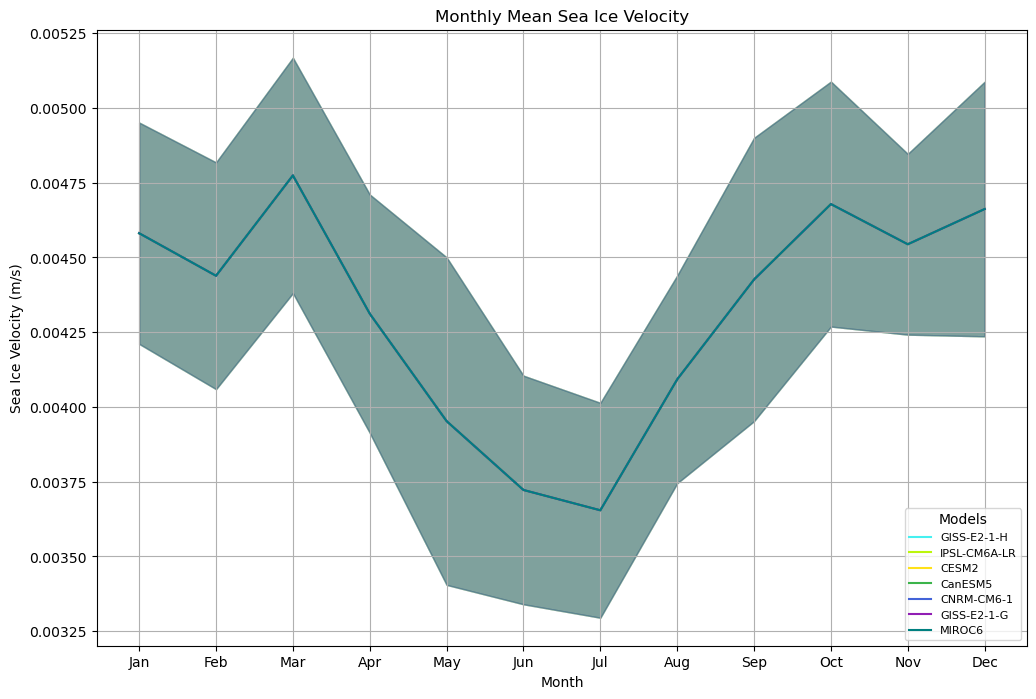

In [32]:
csv_dir = "sispeed_data/"
csv_files = glob.glob(f"{csv_dir}*_sispeed.csv")

model_monthly_means = {}
model_monthly_stds = {}

for csv_file in csv_files:
    model_name = os.path.basename(csv_file).replace("_sispeed.csv", "")
    velocity_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
    monthly_mean = velocity_df.groupby(velocity_df.index.month).mean().mean(axis=1)
    monthly_std = velocity_df.groupby(velocity_df.index.month).std().mean(axis=1)
    model_monthly_means[model_name] = monthly_mean.values
    model_monthly_stds[model_name] = monthly_std.values

monthly_means_df = pd.DataFrame(model_monthly_means, index=np.arange(1, 13))
monthly_stds_df = pd.DataFrame(model_monthly_stds, index=np.arange(1, 13))

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_values = np.arange(1, 13)

plt.figure(figsize=(12, 8))
for model_name in monthly_means_df.columns:
    mean_values = monthly_means_df[model_name].values
    std_values = monthly_stds_df[model_name].values
    color = model_colors.get(model_name, "#000000")
    plt.plot(month_values, mean_values, color=color, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

plt.title('Monthly Mean Sea Ice Velocity')
plt.xlabel('Month')
plt.ylabel('Sea Ice Velocity (m/s)')
plt.xticks(month_values, month_labels)
plt.legend(title='Models', loc='lower right', fontsize=8)
plt.grid(True)
plt.show()


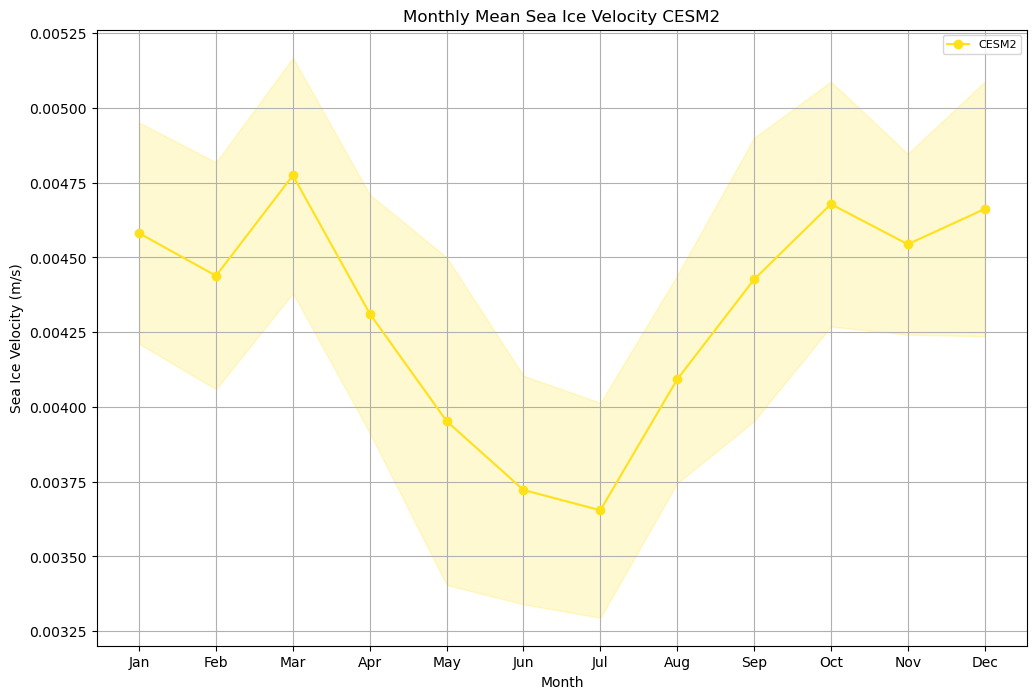

In [35]:
model = "CESM2"
mean_values = monthly_means_df[model].values
std_values = monthly_stds_df[model].values

plt.figure(figsize=(12, 8))
plt.plot(month_values, mean_values, marker='o', color=model_colors.get(model, "#000000"), label=model)
plt.fill_between(month_values, mean_values - std_values, mean_values + std_values, 
                 color=model_colors.get(model, "#000000"), alpha=0.2)
plt.title("Monthly Mean Sea Ice Velocity CESM2")
plt.xlabel("Month")
plt.ylabel("Sea Ice Velocity (m/s)")
plt.xticks(month_values, month_labels)
plt.legend(loc="best", fontsize=8)
plt.grid(True)
plt.show()


In [22]:
print(monthly_means_df)
print(monthly_means_df.describe())


    GISS-E2-1-H  IPSL-CM6A-LR     CESM2   CanESM5  CNRM-CM6-1  GISS-E2-1-G  \
1      0.004581      0.004581  0.004581  0.004581    0.004581     0.004581   
2      0.004439      0.004439  0.004439  0.004439    0.004439     0.004439   
3      0.004774      0.004774  0.004774  0.004774    0.004774     0.004774   
4      0.004312      0.004312  0.004312  0.004312    0.004312     0.004312   
5      0.003953      0.003953  0.003953  0.003953    0.003953     0.003953   
6      0.003722      0.003722  0.003722  0.003722    0.003722     0.003722   
7      0.003654      0.003654  0.003654  0.003654    0.003654     0.003654   
8      0.004092      0.004092  0.004092  0.004092    0.004092     0.004092   
9      0.004426      0.004426  0.004426  0.004426    0.004426     0.004426   
10     0.004678      0.004678  0.004678  0.004678    0.004678     0.004678   
11     0.004544      0.004544  0.004544  0.004544    0.004544     0.004544   
12     0.004662      0.004662  0.004662  0.004662    0.004662   

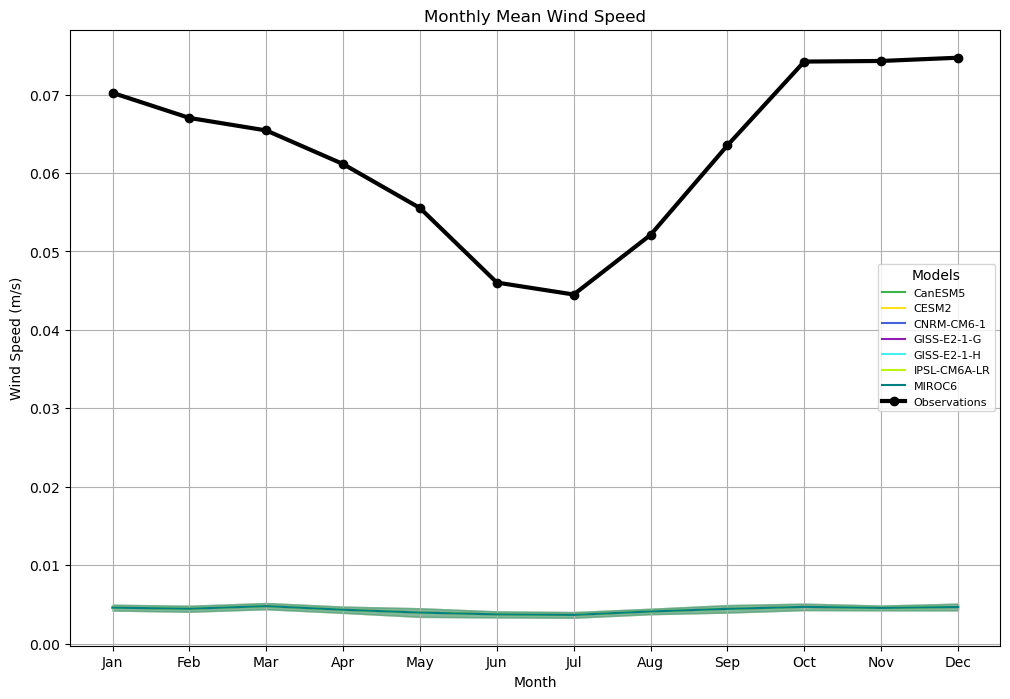

In [31]:
obsvel_file = "/Users/akikomotoki/Desktop/thesis/observational data/nsidc_ice_motion_monthly_1978-2023.nc"
ds = xr.open_dataset(obsvel_file)

obsv_ice_speed = ds['drift_speed'] / 100

obsv_monthly = obsv_ice_speed.resample(time='1M').mean()

obsv_means = obsv_monthly.groupby('time.month').mean(dim='time') # monthly means (average over all years for each month)
obsv_avg = obsv_means.mean(dim=['y', 'x']) # average over the spatial dimensions (latitude and longitude)

obsv_monthly_means = obsv_avg.values # numpy array (1D array with 12 values)

plt.figure(figsize=(12, 8))

for model_name in model_list:
    if model_name not in monthly_means_df.columns:
        continue
    mean_values = monthly_means_df[model_name].values
    std_values = monthly_stds_df[model_name].values
    color = model_colors.get(model_name, "#000000")
    plt.plot(month_values, mean_values, color=color, label=model_name)
    plt.fill_between(month_values, mean_values - std_values, mean_values + std_values,
                     color=color, alpha=0.2)

plt.plot(month_values, obsv_monthly_means, 'k-o', linewidth=3, label="Observations")


plt.title('Monthly Mean Wind Speed')
plt.xlabel('Month')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(range(1, 13), month_labels)
plt.legend(title='Models', loc='best', fontsize=8)
plt.grid(True)
plt.show()

In [ ]:
print(obsv_monthly_means)

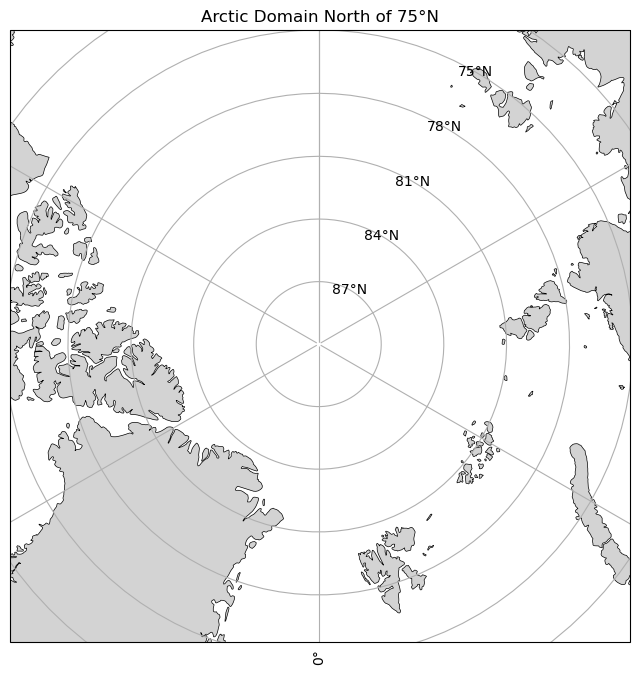

In [103]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# create figure with a polar stereographic projection
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.set_extent([-180, 180, 75, 90], ccrs.PlateCarree())

# add land and coastlines
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.title("Arctic Domain North of 75°N")
plt.show()
